In [29]:
import pyspark 
from pyspark.sql import functions as F

In [2]:
%config Completer.use_jedi = False

In [3]:
from pyspark.sql import SparkSession,functions as d

def session():
    spark= SparkSession.builder.appName("opt1")\
        .master("local")\
    .getOrCreate()

    return spark


In [4]:
spark = session()

In [5]:
spark.version

'3.0.1'

In [6]:
spark.getActiveSession()

In [7]:
%%time
df = spark.read.csv('/Python_Developement/Spark/DATA/Hr5m.csv',header=True,inferSchema=True)

Wall time: 19.6 s


# when we read a simple file 
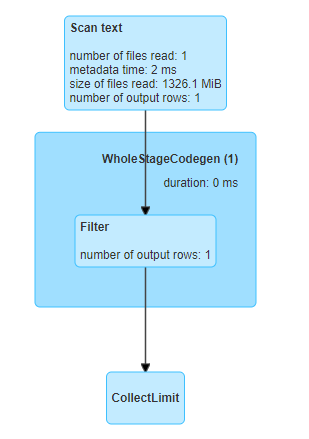

In [8]:
%%time
df.count()

Wall time: 2.91 s


5000000

# When we did count action below plan is executed

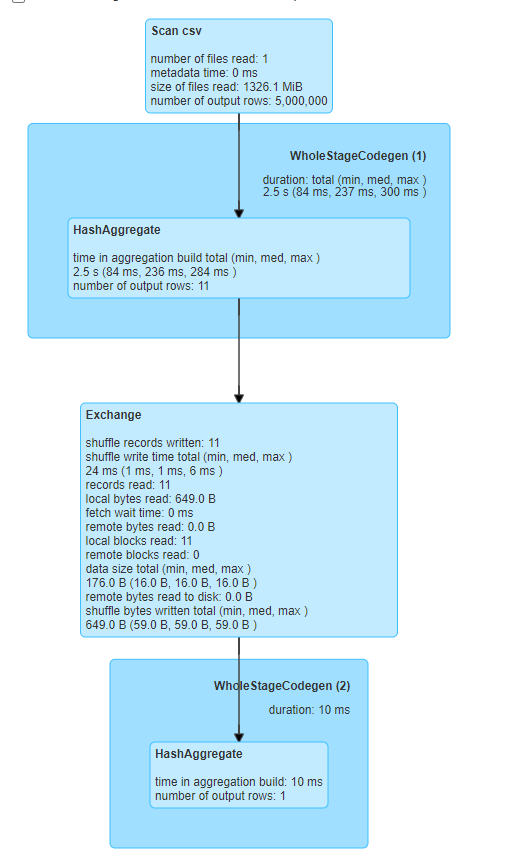

In [9]:
spark.catalog.clearCache()

In [10]:
df.rdd.getNumPartitions()

11

In [11]:
sc = spark.sparkContext

In [12]:
cfg=sc.getConf()

In [13]:
cfg.getAll()

[('spark.master', 'local'),
 ('spark.app.name', 'opt1'),
 ('spark.driver.port', '58801'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'DESKTOP-84G29PO'),
 ('spark.app.id', 'local-1629374322204'),
 ('spark.ui.showConsoleProgress', 'true')]

In [14]:
for x in df.columns:
    df = df.withColumnRenamed(x , x.replace(' ','_'))

In [15]:
from pyspark.sql import functions as f

In [16]:
df.columns

['Emp_ID',
 'Name_Prefix',
 'First_Name',
 'Middle_Initial',
 'Last_Name',
 'Gender',
 'E_Mail',
 "Father's_Name",
 "Mother's_Name",
 "Mother's_Maiden_Name",
 'Date_of_Birth',
 'Time_of_Birth',
 'Age_in_Yrs.',
 'Weight_in_Kgs.',
 'Date_of_Joining',
 'Quarter_of_Joining',
 'Half_of_Joining',
 'Year_of_Joining',
 'Month_of_Joining',
 'Month_Name_of_Joining',
 'Short_Month',
 'Day_of_Joining',
 'DOW_of_Joining',
 'Short_DOW',
 'Age_in_Company_(Years)',
 'Salary',
 'Last_%_Hike',
 'SSN',
 'Phone_No._',
 'Place_Name',
 'County',
 'City',
 'State',
 'Zip',
 'Region',
 'User_Name',
 'Password']

In [17]:
df2 = df.select('Emp_ID','Salary','Last_%_Hike')

In [18]:
%%time
df2.count()

Wall time: 2.82 s


5000000

#select cols and count operation - it still does a full file scan

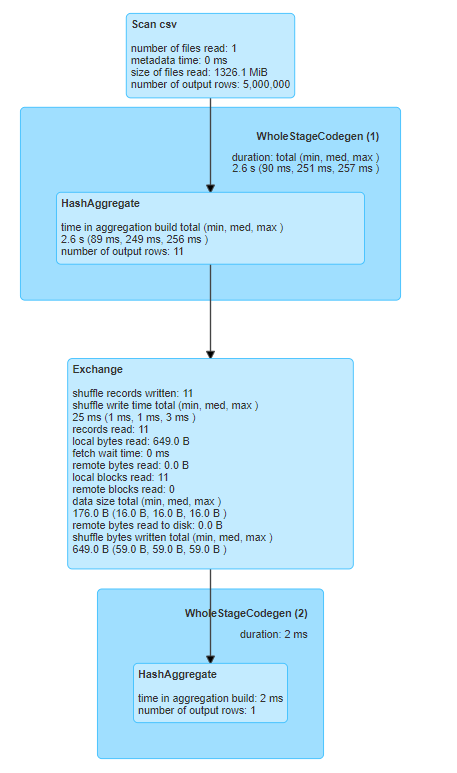

In [ ]:
tmp = df.select('Emp_ID','Salary','Last_%_Hike').cache()

In [ ]:
tmp.is_cached

In [ ]:
%%time
tmp.count()

# SEE Below sql  and above wall time and see the difference

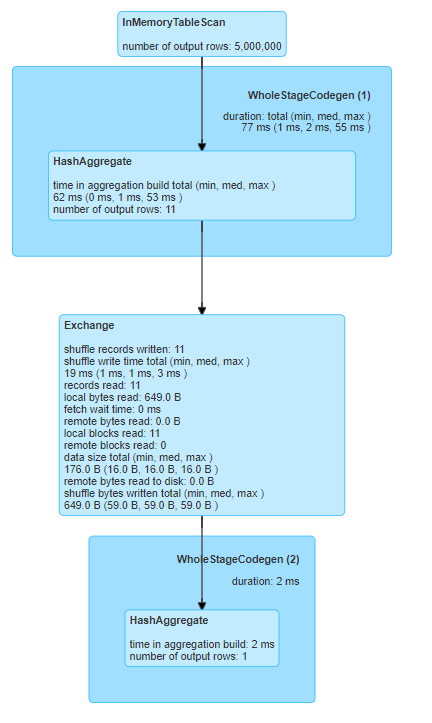

# DEFAULT JOIN 

In [19]:
print(df.rdd.getNumPartitions(),df2.rdd.getNumPartitions())

11 11


In [20]:
j=df.join(df2,on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary']).explain()

== Physical Plan ==
*(5) Project [Emp_Id#169, Salary#41]
+- SortMergeJoin [Emp_ID#169], [Emp_ID#1628], LeftOuter
   :- *(2) Sort [Emp_ID#169 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(Emp_ID#169, 200), true, [id=#107]
   :     +- *(1) Project [Emp ID#16 AS Emp_ID#169, Salary#41]
   :        +- FileScan csv [Emp ID#16,Salary#41] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Python_Developement/Spark/DATA/Hr5m.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Emp ID:int,Salary:int>
   +- *(4) Sort [Emp_ID#1628 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(Emp_ID#1628, 200), true, [id=#115]
         +- *(3) Project [Emp ID#16 AS Emp_ID#1628]
            +- *(3) Filter isnotnull(Emp ID#16)
               +- FileScan csv [Emp ID#16] Batched: false, DataFilters: [isnotnull(Emp ID#16)], Format: CSV, Location: InMemoryFileIndex[file:/Python_Developement/Spark/DATA/Hr5m.csv], PartitionFilters: [], PushedFilters

In [21]:
%%time
j=df.join(df2,on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary'])
j.count()

Wall time: 41 s


33868746

# it took 41 sec for the join 
## observe it has done a full csv/table scan for both df 

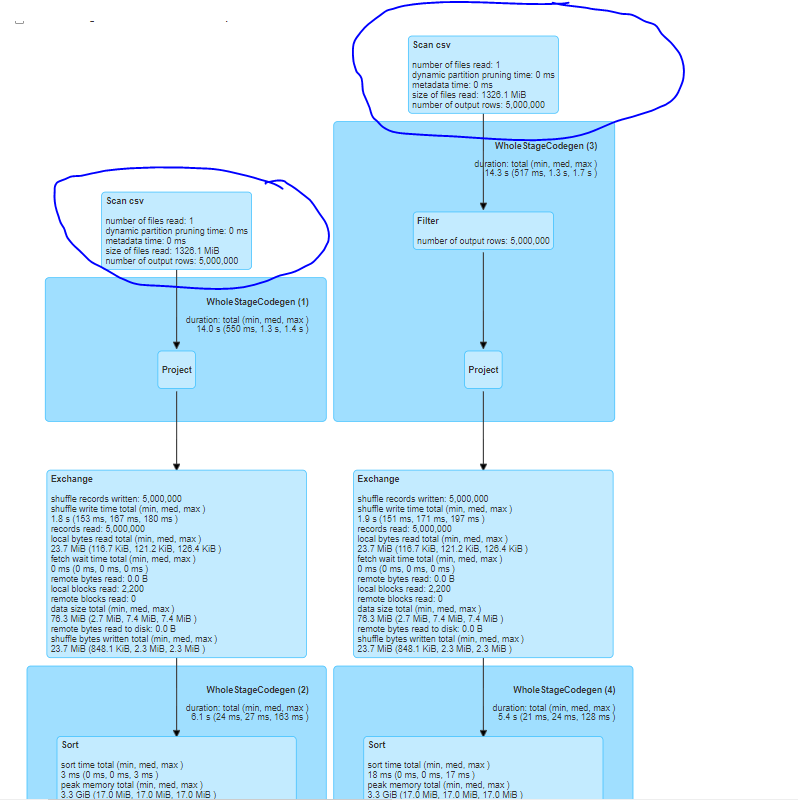

# Work Around

In [22]:
#we will cache a df and observe wall time for join

df2 = df2.cache()

In [24]:
%%time
j=df.join(df2,on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary']).explain()

== Physical Plan ==
*(5) Project [Emp_Id#169, Salary#41]
+- SortMergeJoin [Emp_ID#169], [Emp_ID#2203], LeftOuter
   :- *(2) Sort [Emp_ID#169 ASC NULLS FIRST], false, 0
   :  +- Exchange hashpartitioning(Emp_ID#169, 200), true, [id=#299]
   :     +- *(1) Project [Emp ID#16 AS Emp_ID#169, Salary#41]
   :        +- FileScan csv [Emp ID#16,Salary#41] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Python_Developement/Spark/DATA/Hr5m.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Emp ID:int,Salary:int>
   +- *(4) Sort [Emp_ID#2203 ASC NULLS FIRST], false, 0
      +- Exchange hashpartitioning(Emp_ID#2203, 200), true, [id=#306]
         +- *(3) Filter isnotnull(Emp_ID#2203)
            +- InMemoryTableScan [Emp_ID#2203], [isnotnull(Emp_ID#2203)]
                  +- InMemoryRelation [Emp_ID#2203, Salary#2202, Last_%_Hike#2201], StorageLevel(disk, memory, deserialized, 1 replicas)
                        +- *(1) Project [Emp ID#16 AS Emp_ID#16

In [25]:
%%time
j=df.join(df2,on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary'])
j.count()

Wall time: 26.8 s


33868746

# now it took about 27 seconds 
## observe the below grah we have avoided a full scan hence it performs a faster join

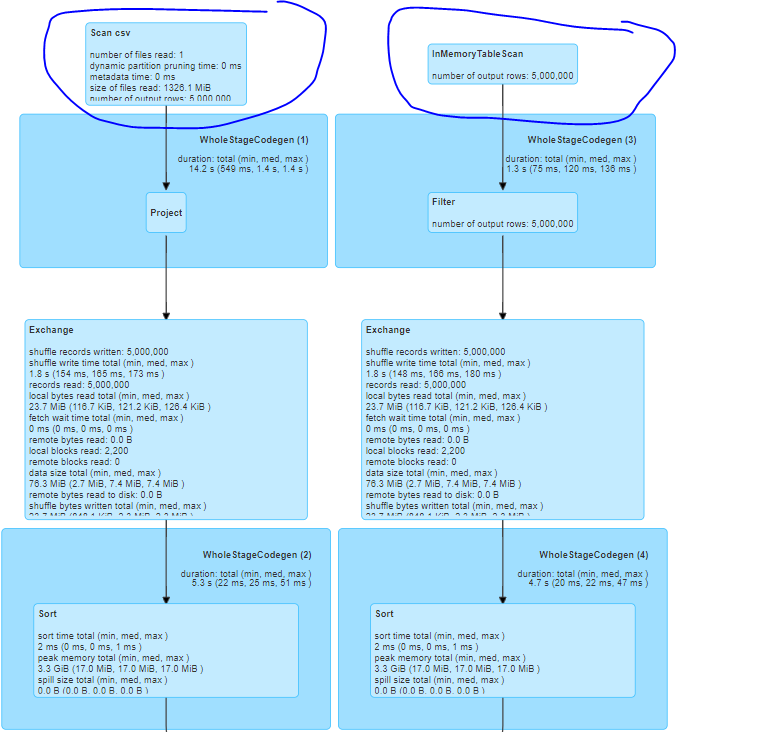

# TRING THE BROADCAST JOIN

In [30]:
j=df.join(F.broadcast(df2),on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary']).explain()

== Physical Plan ==
*(2) Project [Emp_Id#169, Salary#41]
+- *(2) BroadcastHashJoin [Emp_ID#169], [Emp_ID#2631], LeftOuter, BuildRight
   :- *(2) Project [Emp ID#16 AS Emp_ID#169, Salary#41]
   :  +- FileScan csv [Emp ID#16,Salary#41] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Python_Developement/Spark/DATA/Hr5m.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Emp ID:int,Salary:int>
   +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, false] as bigint))), [id=#401]
      +- *(1) Filter isnotnull(Emp_ID#2631)
         +- InMemoryTableScan [Emp_ID#2631], [isnotnull(Emp_ID#2631)]
               +- InMemoryRelation [Emp_ID#2631, Salary#2630, Last_%_Hike#2629], StorageLevel(disk, memory, deserialized, 1 replicas)
                     +- *(1) Project [Emp ID#16 AS Emp_ID#169, Salary#41, Last % Hike#42 AS Last_%_Hike#1157]
                        +- FileScan csv [Emp ID#16,Salary#41,Last % Hike#42] Batched: false, Dat

In [31]:
j=df.join(F.broadcast(df2),on=[df['Emp_ID'] == df2['Emp_ID']],how='left_outer').select(df['Emp_Id'],df2['Salary'])

In [32]:
%%time
j.count()

Wall time: 18.9 s


33868746

# takes about 19 seconds 
## observe the sql graph carefully
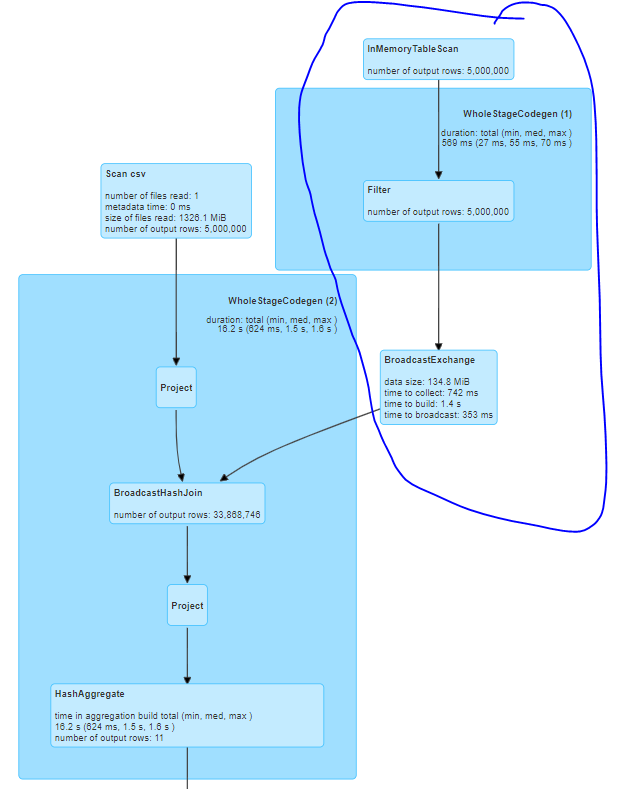


Is broadcasting always good for performance? NOOOOOO
It’s important to remember that when we broadcast, we are hitting on the memory available on each Executor node Can Cause OOME



##  IF we have Skewed Data then  -- For  skewed data  joins

In [33]:
dfc = df2.sample(withReplacement=False,fraction=0.01,seed=42)

In [34]:
dfc.count()

50106

In [ ]:
z=df.join(dfc,on=[df['Emp_ID'] == dfc['Emp_ID']],how='left_outer').select(df['Emp_Id'],dfc['Salary'])

In [ ]:
%%time
z.count()

In [ ]:
"""  Do repartitioning to speed up join  """ 
df = df.repartition(400, F.col("Emp_Id"))

In [ ]:
df.rdd.getNumPartitions()

In [ ]:
%%time
z=df.join(dfc,on=[df['Emp_ID'] == dfc['Emp_ID']],how='left_outer').select(df['Emp_Id'],dfc['Salary'])
z.count()

# Repartioning did worse (   we did not really have a skew issue here )

lets cache the data and do a broadcast join

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold",-12)

In [ ]:
chd = dfc.cache()

In [ ]:
chd.is_cached

In [ ]:
%%time
z=df.join(F.broadcast(dfc),on=[df['Emp_ID'] == dfc['Emp_ID']],how='left_outer').select(df['Emp_Id'],dfc['Salary'])
z.count()

this did well 

In [ ]:
spark.conf.get("spark.sql.autoBroadcastJoinThreshold")